# Temperature modelling

The purpose of this notebook is to model the temperature of the `20190823-NiMesh-PdBurnish-H` experiment during the initial heating phase, i.e. before any hydrogen was added to the system, and to produce plots comparing this model with the temperature evolution during the hydrogen phase.

More details on this experiment can be found at the [blog page](https://gitlab.com/mklilley/lenr/issues/1).

The data can be found in the repo at [/data/20190823-NiMesh-PdBurnish-H](../../data/20190823-NiMesh-PdBurnish-H).

## Libraries

In [107]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import curve_fit

## Source the data

In [108]:
df = pd.read_csv("../../data/20190823-NiMesh-PdBurnish-H/20190823-NiMesh-PdBurnish-H.csv")

## Explore and transform the data

In [109]:
df.head()

time(s)  temperature(C)  pressure(Pa)
0  1566541628           23.75             0
1  1566541658           24.00         -1449
2  1566541688           23.75             0
3  1566541719           23.75         -2899
4  1566541749           23.75          4348

It is convenient to create a column with time in a human readable format for plots. 

In [110]:
df["time"] = pd.to_datetime(df["time(s)"], unit="s")

In [111]:
df.head()

time(s)  temperature(C)  pressure(Pa)                time
0  1566541628           23.75             0 2019-08-23 06:27:08
1  1566541658           24.00         -1449 2019-08-23 06:27:38
2  1566541688           23.75             0 2019-08-23 06:28:08
3  1566541719           23.75         -2899 2019-08-23 06:28:39
4  1566541749           23.75          4348 2019-08-23 06:29:09

In [137]:
px.scatter(df, x="time",y="temperature(C)")

The heater was turned on just after 07:00 and hydrogen was added to the system just after 11:30. 

We therefore create the following subset of the temperature data to build a model from.

In [113]:
heating = df[(df["time"] > "2019-08-23 07:04:00") & (df["time"] < "2019-08-23 11:30:00")].copy()

In [114]:
heating.reset_index(drop = True, inplace=True) 

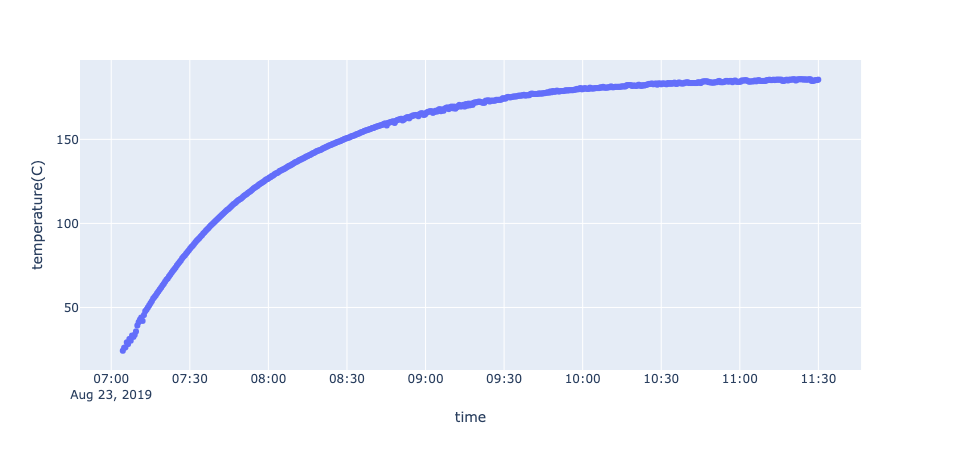

In [136]:
px.scatter(heating, x="time",y="temperature(C)")

When we create a model of the temperature, we will want to work with time in seconds starting from 0. It is helpful therefore to create a new column for this. 

In [116]:
heating["deltat"] = heating["time(s)"] - heating["time(s)"][0]

In [117]:
heating.head()

time(s)  temperature(C)  pressure(Pa)                time  deltat
0  1566543865           24.25         -2899 2019-08-23 07:04:25       0
1  1566543895           26.00             0 2019-08-23 07:04:55      30
2  1566543925           26.25          1449 2019-08-23 07:05:25      60
3  1566543956           29.25         -2899 2019-08-23 07:05:56      91
4  1566543986           28.25             0 2019-08-23 07:06:26     121

## Modelling

### Theory

A simple model of the temperature at the centre of the reactor can be created by solving the 1-D heat equation of the form:

$$ \frac{\partial T}{\partial t} - k \frac{\partial ^2 T}{\partial x^2} = S\left(x\right)$$

on the domain $ -L \leq x \leq L$, with $T \left( x=\pm L \right) =T_0$ and $T\left(t=0\right) = T_0$ and where $S\left(x\right)$ is a constant in time heating source.

There are many online resources to help us solve problems like this - a particularly accessible one is [Introduction to PDFs](https://www.youtube.com/playlist?list=PLdgVBOaXkb9Ab7UM8sCfQWgdbzxkXTNVD) by "Faculty of Khan".

The solution at first looks rather complicated:

$$ T\left(x,t\right) = T_{\infty}\left(x\right) + \sum_0 ^ \infty a_n e^{-k\lambda_n^2 t} \cos\left( \lambda_n x \right)$$

where:

$$ a_n = \frac{2}{L}\int_0 ^ L \cos\left( \lambda_n x \right) \left[ T_0 - T_{\infty}\left(x\right) \right] dx  $$

and:

$$ \lambda_n = \left( n + \frac{1}{2} \right)\frac{\pi}{L} $$

In essence, the solution consists of a steady state part and a transient part that decays away as as $t\rightarrow \infty$.


Simplifications come about by the use of $x=0$ (the centre of the reactor) and the knowledge that for long times only the $n=0$ component is important. An approximate solution can therefore be written in the form:

$$ T\left(0,t\right)  = T_{\infty}\left(0\right) + b e^{-a t}$$

where $a,b,T_{\infty}\left(0\right)$ are constants to be determined by fitting this solution to the temperature data. While it is feasible to determine all 3 parameters in this way, we can use the initial condition $T\left(t=0\right) = T_0$ to determine that $b = T_0 - T_{\infty}\left(0\right)$. The final model is therefore:

$$ T\left(0,t\right)  = T_{\infty}\left(0\right) + \left[ T_0 - T_{\infty}\left(0\right) \right] e^{-a t}$$

*For those concerned that using the initial condition is in conflict with the above argument about long time behaviour, you can use a model like $ T\left(0,t\right)  = T_{\infty}\left(0\right) + c\left[ T_0 - T_{\infty}\left(0\right) \right] e^{-a t}$ and you'll find that c is very close to 1.*

### Implementation 

In [118]:
def func(x, a, Tinf):
    return Tinf + (T0-Tinf) * np.exp(-a * x)

The ambient temperature stayed at around 24C throughout the initial heating phase.

In [119]:
T0 = 24.25

In [120]:
params, cov = curve_fit(func, heating["deltat"], heating["temperature(C)"],p0=[0.001,20.0])

In [135]:
print(f'T_inf =  {params[1].round()}')
print(f'a =  {params[0].round(4)}')

T_inf =  187.0
a =  0.0003


### Visualisation

Create a new column with the model predictions

In [122]:
heating["model"] = func(heating["deltat"], *params)

Create an interactive plot to compare the model and the data.

In [131]:
fig = go.Figure()

# First plot the data
fig.add_trace(go.Scatter(x=heating["time"], y=heating["temperature(C)"],
                    mode='lines+markers',
                    name='data' ))

# Secondly plot the model
fig.add_trace(go.Scatter(x=heating["time"], y=heating["model"],
                    mode='lines',
                    name='model',opacity=1,line_color="#ff7f0e"))

# Adjust size and axis labels
fig.update_layout(
    autosize=False,
    width=900,
    height=800,
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="time"
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="temperature(C)"
        )
    )
)

# Show an interactive plot
fig.show()

# Save the plot as png
fig.write_image("temperature-model-01.png")

Now let's look at the model predictions for later times, i.e. during the hydrogen phase, and compare to the temperature data.

In [124]:
df["deltat"] = df["time(s)"] - heating["time(s)"][0]

In [125]:
df["model"] = func(df["deltat"], *params)

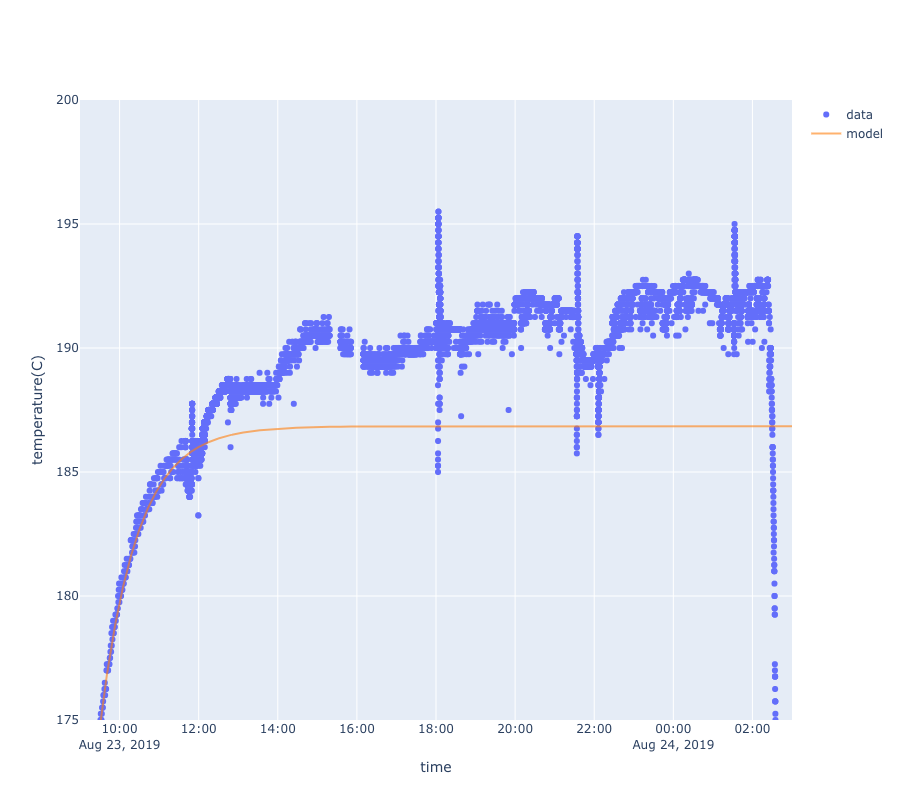

In [126]:
fig = go.Figure()

# First plot the data
fig.add_trace(go.Scatter(x=df["time"], y=df["temperature(C)"],
                    mode='markers',
                    name='data'))

# Secondly plot the model
fig.add_trace(go.Scatter(x=df["time"], y=df["model"],
                    mode='lines',
                    name='model',opacity=0.6, line_color="#ff7f0e"))

# Adjust size and axis labels
fig.update_layout(
    autosize=False,
    width=900,
    height=800,
    xaxis=go.layout.XAxis(
        range = ["2019-08-23 09:00:00","2019-08-24 03:00:00"],
        title=go.layout.xaxis.Title(
            text="time"
        )
    ),
    yaxis=go.layout.YAxis(
        range = [175,200],
        title=go.layout.yaxis.Title(
            text="temperature(C)"
        )
    )

)

# Using the renderer option requires us to install some extra packages
# cf https://plot.ly/python/renderers/ and https://plot.ly/python/static-image-export/
# Using fig.show() makes an interactive graph - it will just make the notebook slow down a lot
fig.show(renderer="png",width=900, height=800)

# Save the plot as png
fig.write_image("temperature-model-02.png")

The errors in the temperature data are ±1.5C in this temperature range.  More details about the data can be found at [/data/20190823-NiMesh-PdBurnish-H](https://gitlab.com/mklilley/lenr/tree/work-in-progress/data/20190823-NiMesh-PdBurnish-H).

We should therefore add error bars to the data and the model, so that any subsequent interpretations will be more meaningful.

To calculate upper and lower bounds for the temperature model, we create 1000 versions of the model based on temperature data that's modified to include a uniformly distributed random error (up to ±1.5C) at each point. The 1000 models are then used to make temperature predictions and the maximum and minimum predictions at each point are taken as the upper and lower bounds.

In [127]:
high = df["model"].copy()
low = df["model"].copy()

for i in range(0,1000):
    errors = np.random.uniform(-1.5,1.5,len(heating))
    params, cov = curve_fit(func, heating["deltat"], heating["temperature(C)"]+errors,p0=[0.001,20.0])
    model = func(df["deltat"], *params)
    high[model>high] = model[model>high]
    low[model<low] = model[model<low]
    
df["model_upper"] = high
df["model_lower"] = low

In [128]:
df.sample()

time(s)  temperature(C)  pressure(Pa)                time  deltat  \
4866  1566564696           188.0        188406 2019-08-23 12:51:36   20831   

           model  model_upper  model_lower  
4866  186.511444   186.701611   186.295875

In [129]:
fig = go.Figure()

# First plot the data
fig.add_trace(go.Scatter(x=df["time"], y=df["temperature(C)"],
                    mode='markers',line_color='#4664f5',
                    name='data'))

# Next plot the data including the error bars and give it an opacity - this will give the error bars a muted colour
fig.add_trace(go.Scatter(x=df["time"], y=df["temperature(C)"],line_color='#4664f5',
                    mode='markers',opacity=0.6,showlegend=False,
                    name='data',error_y = dict(
                        type='constant',
                        value=1.5)))

# Now plot the model lower bound
fig.add_trace(go.Scatter(x=df["time"], y=df["model_lower"],
                    mode='lines', showlegend=False,
                    name='lower bound',opacity=0.6,line_color='#ff7f0e'))

# Now plot the model upper bound
fig.add_trace(go.Scatter(x=df["time"], y=df["model_upper"],
                    mode='lines', showlegend=False,
                    name='upper bound',opacity=0.6,fill='tonexty',line_color='#ff7f0e'))

# Now plot the model
fig.add_trace(go.Scatter(x=df["time"], y=df["model"],
                    mode='lines',
                    name='model',opacity=0.6,line_color='#ff7f0e'))

# Adjust size and axis labels
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    xaxis=go.layout.XAxis(
        range = ["2019-08-23 09:00:00","2019-08-24 03:00:00"],
        title=go.layout.xaxis.Title(
            text="time"
        )
    ),
    yaxis=go.layout.YAxis(
        range = [175,200],
        title=go.layout.yaxis.Title(
            text="temperature(C)"
        )
    )

)

# Using the renderer option requires us to install some extra packages
# cf https://plot.ly/python/renderers/ and https://plot.ly/python/static-image-export/
# Using fig.show() makes an interactive graph - it will just make the notebook slow down a lot
fig.show(renderer="png",width=900, height=800)

# Save the plot as png
fig.write_image("temperature-model-03.png")